<a href="https://colab.research.google.com/github/RegNLP/ReguSum/blob/main/ReguSum_Data_Preparation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


Retrieving folder contents
Processing file 1UUdNdznSMe8YIyh4SxwaiqCwM6tFZJN9 m6g-oqrn-vuxf.csv
Processing file 1VC9css9H1lHCS_H8rDeHxu7M4J9SaUcw m6i-1gtx-mmls.csv
Processing file 1bxlvaN07RIUd6GwYF7SJCpd1xnVyJR8j m6i-1jxq-2dx1.csv
Processing file 1P7XXUYQAcEaHGl-1Sw4oWwQ8EwKkVTSu m6i-1lz5-v9ud.csv
Processing file 1IND51zFqJdHXCi2HEnuVwwm6z0Lz4-GJ m6i-1pux-9azw.csv
Processing file 14JTtvX7Q8X8h2VPXgCNbS-8S7yX4VGhr m6i-1sj5-t1tn.csv
Processing file 1UCX0tI0gfriQnqXfJ7XTrTEh6-znBa7l m6i-1tht-4u4x.csv
Processing file 17lxQwqeqSp0XKC5geMkfPJRI40rs1DCn m6i-1un0-8mu9.csv
Processing file 1Md7OIWzEm8HL7IoNzxSYkacs9j509R5e m6i-1vl3-nybo.csv
Processing file 1QodqHz3sGPHpWSHrLS__QJ4iWvWUheVk m6i-1wpl-dukq.csv
Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=1UUdNdznSMe8YIyh4SxwaiqCwM6tFZJN9
To: /content/data/DocumentsInfo/m6g-oqrn-vuxf.csv
100% 28.5k/28.5k [00:00<00:00, 66.8MB/s]
Downloading

[warn] Could not parse DocumentID from https://downloads.regulations.gov/IRS_FRDOC_0001-2179/content.htm
[warn] Could not parse DocumentID from https://downloads.regulations.gov/IRS_FRDOC_0001-2208/content.htm
[warn] Could not parse DocumentID from https://downloads.regulations.gov/IRS_FRDOC_0001-2209/content.htm
[warn] Could not parse DocumentID from https://downloads.regulations.gov/IRS_FRDOC_0001-2211/content.htm
[warn] Could not parse DocumentID from https://downloads.regulations.gov/IRS_FRDOC_0001-2248/content.htm
[warn] Could not parse DocumentID from https://downloads.regulations.gov/IRS_FRDOC_0001-2267/content.htm
[warn] Could not parse DocumentID from https://downloads.regulations.gov/IRS_FRDOC_0001-1901/content.htm
[warn] Could not parse DocumentID from https://downloads.regulations.gov/IRS_FRDOC_0001-1903/content.htm
[warn] Could not parse DocumentID from https://downloads.regulations.gov/IRS_FRDOC_0001-2092/content.htm
[warn] Could not parse DocumentID from https://download

[ok] Processed 345 documents (skipped=16).
[ok] Dataset saved -> /content/data/regusum_dataset.json
Loaded 345 documents.


/tmp/ipython-input-3403219847.py:293: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  doc_dist = df.groupby(["Agency","DocLengthBin"]).size().unstack(fill_value=0)
/tmp/ipython-input-3403219847.py:295: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sum_dist = df.groupby(["Agency","SumLengthBin"]).size().unstack(fill_value=0)


[ok] Stats + distributions saved to /content/stats
[ok] Plots saved to /content/stats
Mounted at /content/drive
[ok] Copied dataset + stats to /content/drive/MyDrive/ReguSum-GithubRepo


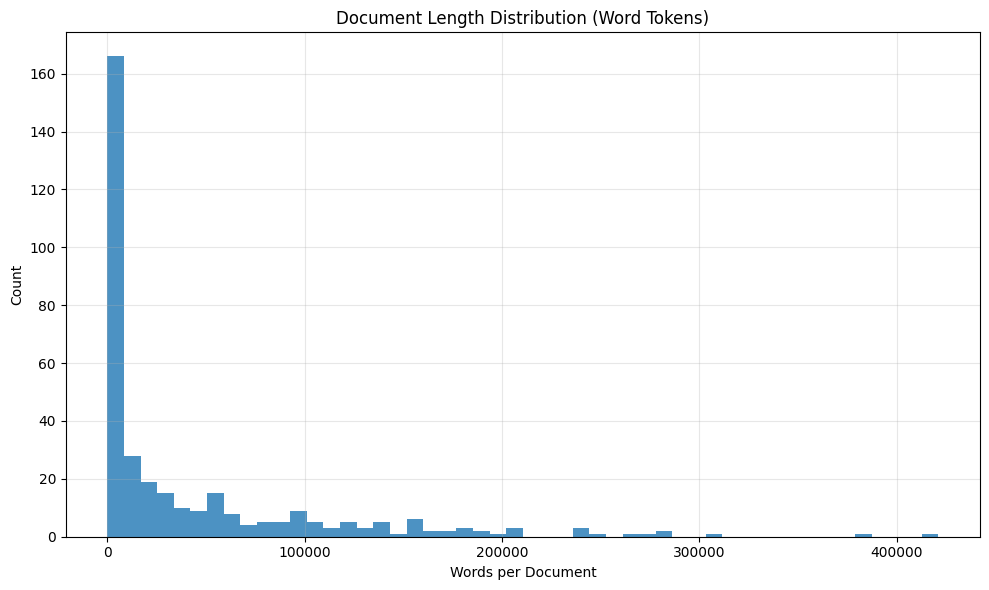

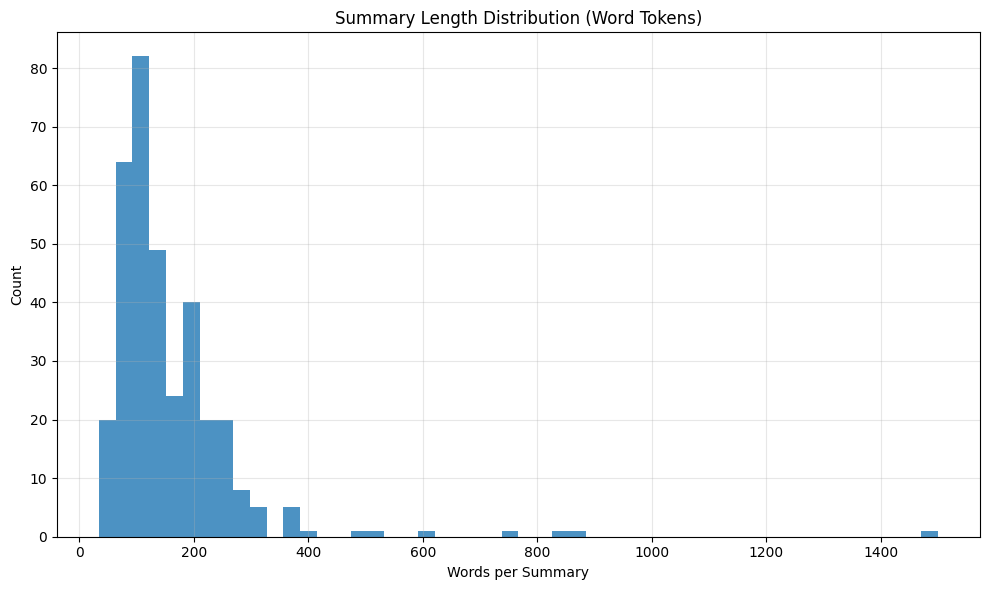

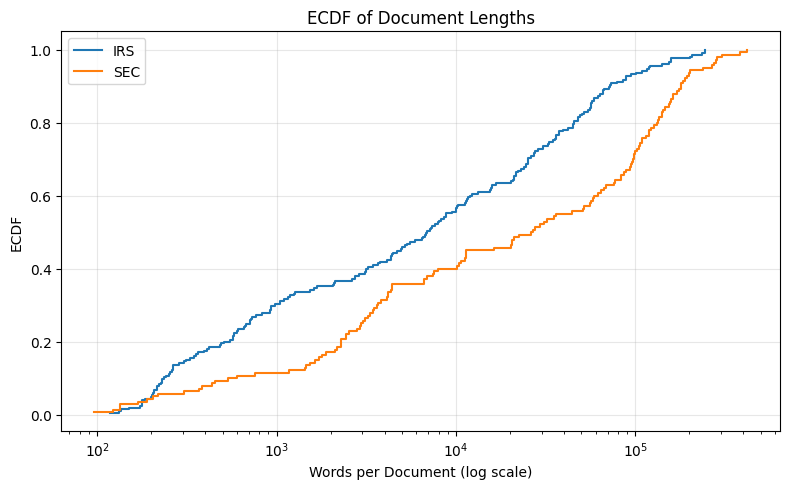

In [2]:
# ===========================================
# ReguSum: End-to-end build + stats (with stats/ folder and optional Drive save)
# ===========================================

# -----------------------------
# Config
# -----------------------------
FOLDER_ID = "1hDL5CCE89Qg4ajMXfUGxlPEY6cFBa--N"    # your shared DocumentsInfo folder
BASE_DIR  = "/content"                              # base working dir
DATA_DIR  = f"{BASE_DIR}/data"
DOCINFO_DIR = f"{DATA_DIR}/DocumentsInfo"
HTML_DIR    = f"{DATA_DIR}/DocumentsHTML"
DATASET_PATH = f"{DATA_DIR}/regusum_dataset.json"

STATS_DIR = f"{BASE_DIR}/stats"                     # <-- stats folder
SAVE_TO_DRIVE = True                               # <-- set True to copy outputs to Drive
DRIVE_DIR = "/content/drive/MyDrive/ReguSum-GithubRepo"        # where to copy if SAVE_TO_DRIVE=True

# -----------------------------
# Step 0: deps & dirs
# -----------------------------
!pip -q install gdown pandas beautifulsoup4 lxml tqdm requests nltk matplotlib numpy

import os, re, glob, json, time
from pathlib import Path
from urllib.parse import urlparse

import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
from tqdm import tqdm
import nltk
nltk.download("punkt", quiet=True)
nltk.download('punkt_tab')
from nltk.tokenize import sent_tokenize, word_tokenize

# Make dirs
Path(DOCINFO_DIR).mkdir(parents=True, exist_ok=True)
Path(HTML_DIR).mkdir(parents=True, exist_ok=True)
Path(STATS_DIR).mkdir(parents=True, exist_ok=True)

# -----------------------------
# Step 1: Download DocumentsInfo CSVs
# -----------------------------
print("Downloading 'DocumentsInfo' from Google Drive...")
!gdown --folder "https://drive.google.com/drive/folders/{FOLDER_ID}" -O {DOCINFO_DIR}

csv_paths = sorted(glob.glob(os.path.join(DOCINFO_DIR, "*.csv")))
print(f"\nFound {len(csv_paths)} CSV file(s) in {DOCINFO_DIR}:\n")
for p in csv_paths[:10]:
    print(" -", os.path.basename(p))
if len(csv_paths) > 10:
    print(f" ... and {len(csv_paths)-10} more.")

# -----------------------------
# Step 2: Parse CSVs and download only .htm files (saved as <DocumentID>.htm)
# -----------------------------
SPLIT_RE = re.compile(r'[,\s;]+', re.IGNORECASE)

def extract_htm_urls(cell_value: str):
    if pd.isna(cell_value):
        return []
    parts = [p.strip().rstrip(').,;\'"') for p in SPLIT_RE.split(str(cell_value).strip()) if p.strip()]
    return [u for u in parts if re.search(r'\.(htm|html)(\?|#|$)', u, re.IGNORECASE)]

def pick_content_column(df: pd.DataFrame):
    if "Content Files" in df.columns:
        return "Content Files"
    for c in df.columns:
        lc = c.lower()
        if "content" in lc and "file" in lc:
            return c
    return None

SESSION = requests.Session()
SESSION.headers.update({
    "User-Agent": "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/124.0 Safari/537.36"
})

def fetch_htm(url: str, dest_dir: Path) -> Path | None:
    try:
        m = re.search(r'/([A-Z]+-\d{4}-\d+-\d+)/content', url)
        if not m:
            print(f"[warn] Could not parse DocumentID from {url}")
            return None
        doc_id = m.group(1)
        out_path = Path(dest_dir) / f"{doc_id}.htm"
        if out_path.exists() and out_path.stat().st_size > 0:
            return out_path
        r = SESSION.get(url, timeout=30, allow_redirects=True)
        if r.status_code != 200:
            print(f"[warn] {r.status_code} for {url}")
            return None
        out_path.write_bytes(r.content)
        return out_path
    except Exception as e:
        print(f"[warn] Download failed {url}: {e}")
        return None

all_htm_urls = []
for csv_path in csv_paths:
    df = pd.read_csv(csv_path, dtype=str, keep_default_na=False)
    col = pick_content_column(df)
    if not col:
        print(f"[skip] No 'Content Files' column in {os.path.basename(csv_path)}")
        continue
    for cell in df[col]:
        all_htm_urls.extend(extract_htm_urls(cell))

seen = set()
unique_htm_urls = [u for u in all_htm_urls if not (u in seen or seen.add(u))]
print(f"Discovered {len(unique_htm_urls)} unique .htm URLs.")

saved_paths = []
for url in tqdm(unique_htm_urls, desc="Downloading .htm files"):
    p = fetch_htm(url, Path(HTML_DIR))
    if p:
        saved_paths.append(p)

print(f"\nSaved {len(saved_paths)} HTM files to: {Path(HTML_DIR).resolve()}")
if saved_paths[:5]:
    print("Examples:")
    for p in saved_paths[:5]:
        print(" -", Path(p).name)

# -----------------------------
# Step 3: Parse .htm -> regusum_dataset.json (skip empty/missing gold summary)
# -----------------------------
MIN_SECTION_LENGTH = 100

def segment_content(main_content):
    if not main_content:
        return []
    sections = []
    major_parts = re.split(
        r'\n(?=I\. |II\. |III\. |IV\. |V\. |VI\. |VII\. |VIII\. |IX\. |X\. |SUMMARY:|DATES:|FOR FURTHER INFORMATION CONTACT:)',
        main_content
    )
    major_parts = [part.strip() for part in major_parts if part and part.strip()]
    if len(major_parts) > 1:
        for part in major_parts:
            lines = part.split('\n')
            header, text = lines[0].strip(), '\n'.join(lines[1:]).strip()
            if len(header) < 200 and text:
                sections.append({"header": header, "text": text})
            else:
                if sections:
                    sections[-1]['text'] += '\n\n' + part
                else:
                    sections.append({"header": "Introduction", "text": part})
    else:
        sections.append({"header": "Main Content", "text": main_content})
    final_sections, temp_text_buffer = [], ""
    for section in reversed(sections):
        if len(section['text']) < MIN_SECTION_LENGTH and final_sections:
            temp_text_buffer = section['header'] + '\n\n' + section['text'] + '\n\n' + temp_text_buffer
        else:
            section['text'] += ('\n\n' + temp_text_buffer) if temp_text_buffer else ''
            final_sections.append(section)
            temp_text_buffer = ""
    if temp_text_buffer and final_sections:
        final_sections[-1]['text'] = temp_text_buffer + final_sections[-1]['text']
    return list(reversed(final_sections))

def extract_text_from_html(file_path):
    try:
        with open(file_path, "r", encoding="utf-8", errors="ignore") as file:
            soup = BeautifulSoup(file, "html.parser")
        pre_tag = soup.find("pre")
        return (pre_tag.get_text("\n\n") if pre_tag else soup.get_text("\n\n")), soup
    except Exception as e:
        print(f"Error reading {os.path.basename(file_path)}: {e}")
        return None, None

def extract_title(soup):
    return soup.title.string.strip() if soup and soup.title and soup.title.string else "Title Not Found"

def parse_regulation_file(file_path):
    doc_id = os.path.splitext(os.path.basename(file_path))[0]
    try:
        full_text, soup = extract_text_from_html(file_path)
        if not full_text:
            return None
        summary_match = re.search(
            r"SUMMARY:(.*?)(?=SUPPLEMENTARY INFORMATION:|FOR FURTHER INFORMATION CONTACT:)",
            full_text, re.DOTALL | re.IGNORECASE
        )
        if not summary_match:
            return None
        gold_summary = summary_match.group(1).strip()
        if not gold_summary:
            return None
        content_match = re.search(r"SUPPLEMENTARY INFORMATION:", full_text, re.IGNORECASE)
        main_content = full_text[content_match.end():].strip() if content_match else full_text
        sections = segment_content(main_content) or [{"header": "Main Content", "text": main_content}]
        title = extract_title(soup)
        agency_id = doc_id.split('-')[0] if '-' in doc_id else "UNKNOWN"
        topics_match = re.search(
            r"List of Subjects in.*?PART \d+(.*?)(?:Correction of Publication|Accordingly|PART)",
            full_text, re.DOTALL | re.IGNORECASE
        )
        topics = re.sub(r'\s+', ' ', topics_match.group(1).strip()).replace('\n', ',') if topics_match else "Topics Not Found"
        return {
            "ID": doc_id,
            "gold_summary": gold_summary,
            "Agency ID": agency_id,
            "Title": title,
            "Topics": topics,
            "original_content": main_content,
            "Sections": sections
        }
    except Exception as e:
        print(f"Could not process file {doc_id}. Error: {e}")
        return None

# Build dataset
html_files = sorted([f for f in os.listdir(HTML_DIR) if f.lower().endswith((".htm", ".html"))])
print(f"Found {len(html_files)} HTM/HTML files to process.")
records, skipped = [], 0
for fn in html_files:
    rec = parse_regulation_file(os.path.join(HTML_DIR, fn))
    if rec and rec.get("gold_summary"):
        records.append(rec)
    else:
        skipped += 1

with open(DATASET_PATH, "w", encoding="utf-8") as f:
    json.dump(records, f, indent=2, ensure_ascii=False)
print(f"[ok] Processed {len(records)} documents (skipped={skipped}).")
print(f"[ok] Dataset saved -> {DATASET_PATH}")

# -----------------------------
# Step 4: Stats + distributions + plots (saved into stats/)
# -----------------------------
def count_words(text: str) -> int:
    return len(word_tokenize(text)) if text else 0

def count_sentences(text: str) -> int:
    return len(sent_tokenize(text)) if text else 0

with open(DATASET_PATH, "r", encoding="utf-8") as f:
    dataset = json.load(f)
print(f"Loaded {len(dataset)} documents.")

rows = []
for doc in dataset:
    agency = doc.get("Agency ID", "UNKNOWN")
    doc_text = doc.get("original_content", "")
    sum_text = doc.get("gold_summary", "")
    rows.append({
        "ID": doc.get("ID", ""),
        "Agency": agency,
        "DocWords": count_words(doc_text),
        "DocSentences": count_sentences(doc_text),
        "SummaryWords": count_words(sum_text),
        "SummarySentences": count_sentences(sum_text),
        "NumSections": len(doc.get("Sections", []))
    })
df = pd.DataFrame(rows)

# Aggregate stats
agg = df.groupby("Agency").agg(
    n_docs=("ID", "count"),
    avg_doc_words=("DocWords", "mean"),
    avg_doc_sents=("DocSentences", "mean"),
    avg_sum_words=("SummaryWords", "mean"),
    avg_sum_sents=("SummarySentences", "mean"),
    avg_sections=("NumSections", "mean")
).reset_index()
for col in agg.columns:
    if col.startswith("avg_"):
        agg[col] = agg[col].round(1)
total = pd.DataFrame([{
    "Agency": "Total",
    "n_docs": df.shape[0],
    "avg_doc_words": df["DocWords"].mean().round(1),
    "avg_doc_sents": df["DocSentences"].mean().round(1),
    "avg_sum_words": df["SummaryWords"].mean().round(1),
    "avg_sum_sents": df["SummarySentences"].mean().round(1),
    "avg_sections": df["NumSections"].mean().round(2)
}])
stats_df = pd.concat([agg, total], ignore_index=True)

# Binned distributions
bins = [0,128,256,512,1024,2048,4096,8192,np.inf]
labels = ["0-128","128-256","256-512","512-1024","1024-2048","2048-4096","4096-8192","8192+"]

df["DocLengthBin"] = pd.cut(df["DocWords"], bins=bins, labels=labels, right=False)
df["SumLengthBin"] = pd.cut(df["SummaryWords"], bins=bins, labels=labels, right=False)

doc_dist = df.groupby(["Agency","DocLengthBin"]).size().unstack(fill_value=0)
doc_dist.loc["Total"] = doc_dist.sum()
sum_dist = df.groupby(["Agency","SumLengthBin"]).size().unstack(fill_value=0)
sum_dist.loc["Total"] = sum_dist.sum()

# Save tables into stats/
stats_csv = f"{STATS_DIR}/regusum_stats.csv"
stats_md  = f"{STATS_DIR}/regusum_stats.md"
doc_csv   = f"{STATS_DIR}/regusum_doc_length_distribution.csv"
doc_md    = f"{STATS_DIR}/regusum_doc_length_distribution.md"
sum_csv   = f"{STATS_DIR}/regusum_sum_length_distribution.csv"
sum_md    = f"{STATS_DIR}/regusum_sum_length_distribution.md"

stats_df.to_csv(stats_csv, index=False)
with open(stats_md,"w",encoding="utf-8") as f: f.write(stats_df.to_markdown(index=False))
doc_dist.to_csv(doc_csv)
with open(doc_md,"w",encoding="utf-8") as f: f.write(doc_dist.to_markdown())
sum_dist.to_csv(sum_csv)
with open(sum_md,"w",encoding="utf-8") as f: f.write(sum_dist.to_markdown())

print(f"[ok] Stats + distributions saved to {STATS_DIR}")

# Plots
plt.figure(figsize=(10,6))
plt.hist(df["DocWords"], bins=50, alpha=0.8)
plt.title("Document Length Distribution (Word Tokens)")
plt.xlabel("Words per Document"); plt.ylabel("Count"); plt.grid(True, alpha=0.3)
plt.tight_layout(); plt.savefig(f"{STATS_DIR}/doc_length_hist.png", dpi=200)

plt.figure(figsize=(10,6))
plt.hist(df["SummaryWords"], bins=50, alpha=0.8)
plt.title("Summary Length Distribution (Word Tokens)")
plt.xlabel("Words per Summary"); plt.ylabel("Count"); plt.grid(True, alpha=0.3)
plt.tight_layout(); plt.savefig(f"{STATS_DIR}/summary_length_hist.png", dpi=200)

def ecdf(x):
    x = np.asarray(x); x = x[~np.isnan(x)]
    xs = np.sort(x); ys = np.arange(1, len(xs)+1)/len(xs)
    return xs, ys

plt.figure(figsize=(8,5))
for agency, sub in df.groupby("Agency"):
    xs, ys = ecdf(sub["DocWords"])
    plt.step(xs, ys, where="post", label=f"{agency}")
plt.xscale("log"); plt.xlabel("Words per Document (log scale)"); plt.ylabel("ECDF")
plt.title("ECDF of Document Lengths"); plt.legend(); plt.grid(True, alpha=0.3)
plt.tight_layout(); plt.savefig(f"{STATS_DIR}/doc_length_ecdf.png", dpi=200)

print(f"[ok] Plots saved to {STATS_DIR}")

# -----------------------------
# Optional: Save everything to Drive
# -----------------------------
if SAVE_TO_DRIVE:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=False)
    Path(DRIVE_DIR).mkdir(parents=True, exist_ok=True)
    # copy dataset
    !cp -f "{DATASET_PATH}" "{DRIVE_DIR}/regusum_dataset.json"
    # copy stats dir contents
    !cp -rf "{STATS_DIR}" "{DRIVE_DIR}/"
    print(f"[ok] Copied dataset + stats to {DRIVE_DIR}")


In [3]:
# ===== Step 4: Inspect the built dataset (IDs, Titles, Section headers) =====
import json, os
from pathlib import Path
import pandas as pd

# --- Options ---
USE_DRIVE_DATASET = False  # set True to use your Drive path below
DRIVE_DATASET_PATH = ""

# Default to the dataset built in Step 3:
LOCAL_DATASET_PATH = "/content/data/regusum_dataset.json"

# Where to write a compact overview CSV (optional)
OVERVIEW_CSV_PATH = "/content/data/regusum_dataset_overview.csv"

# --- Mount Drive only if needed ---
if USE_DRIVE_DATASET:
    from google.colab import drive
    drive.mount('/content/drive')

# --- Resolve path ---
DATASET_PATH = DRIVE_DATASET_PATH if USE_DRIVE_DATASET else LOCAL_DATASET_PATH
print(f"Using dataset: {DATASET_PATH}")

def inspect_all_documents(dataset_path: str, write_overview_csv: bool = True):
    """
    Loads the dataset and prints ID, Title, and section headers for each document.
    Also writes an overview CSV with basic stats per document (optional).
    """
    try:
        if not os.path.exists(dataset_path):
            print(f"Error: File not found at '{dataset_path}'")
            return

        with open(dataset_path, "r", encoding="utf-8") as f:
            dataset = json.load(f)

        if not dataset:
            print("The dataset is empty. Nothing to display.")
            return

        print("--- Document IDs and Section Headers ---")

        total_docs = 0
        docs_with_multiple_sections = 0
        total_sections = 0

        # For optional CSV overview
        overview_rows = []

        for document in dataset:
            total_docs += 1

            doc_id = document.get("ID", "ID Not Found")
            title = document.get("Title", "Title Not Found")
            sections = document.get("Sections", []) if isinstance(document.get("Sections", []), list) else []

            num_sections = len(sections)
            total_sections += num_sections
            if num_sections > 1:
                docs_with_multiple_sections += 1

            print(f"\nID: {doc_id}")
            print(f"Title: {title}")
            print(f"Sections Found: {num_sections}")

            headers = []
            if sections:
                for section in sections:
                    header = section.get("header", "Header Not Found")
                    headers.append(header)
                    print(f"  - Header: {header}")
            else:
                print("  - No sections found for this document.")

            overview_rows.append({
                "ID": doc_id,
                "Title": title,
                "NumSections": num_sections,
                "SectionHeaders": " | ".join(headers)
            })

        # --- Final Summary ---
        print("\n" + "="*40)
        print("--- Dataset Inspection Summary ---")
        print(f"Total Documents Processed: {total_docs}")
        print(f"Documents with Multiple Sections: {docs_with_multiple_sections}")
        if total_docs > 0:
            avg_sections = round(total_sections / total_docs, 2)
            print(f"Average Sections per Document: {avg_sections}")
        print("="*40)

        # Optional CSV
        if write_overview_csv:
            df = pd.DataFrame(overview_rows)
            Path(os.path.dirname(OVERVIEW_CSV_PATH)).mkdir(parents=True, exist_ok=True)
            df.to_csv(OVERVIEW_CSV_PATH, index=False)
            print(f"\n[ok] Wrote overview CSV -> {OVERVIEW_CSV_PATH}")

    except Exception as e:
        print(f"An error occurred: {e}")

# Run the inspection
inspect_all_documents(DATASET_PATH, write_overview_csv=True)


Using dataset: /content/data/regusum_dataset.json
--- Document IDs and Section Headers ---

ID: IRS-2008-0041-0003
Title: Federal Register, Volume 85 Issue 113 (Thursday, June 11, 2020)
Sections Found: 1
  - Header: Main Content

ID: IRS-2008-0053-0009
Title: Federal Register, Volume 88 Issue 146 (Tuesday, August 1, 2023)
Sections Found: 1
  - Header: Main Content

ID: IRS-2008-0092-0007
Title: Federal Register, Volume 85 Issue 162 (Thursday, August 20, 2020)
Sections Found: 1
  - Header: Main Content

ID: IRS-2011-0050-0006
Title: Federal Register, Volume 85 Issue 46 (Monday, March 9, 2020)
Sections Found: 1
  - Header: Main Content

ID: IRS-2014-0001-0014
Title: Federal Register, Volume 85 Issue 88 (Wednesday, May 6, 2020)
Sections Found: 1
  - Header: Main Content

ID: IRS-2014-0030-0004
Title: Federal Register, Volume 89 Issue 231 (Monday, December 2, 2024)
Sections Found: 14
  - Header: Authority
  - Header: I. Overlapping Economic Risk of Loss
  - Header: II. Tiered Partnerships


In [4]:
dowload(/content/stats)

SyntaxError: invalid syntax (ipython-input-2372805549.py, line 1)

In [9]:
import os
from google.colab import files

# Replace with the actual path to your folder
folder_path = "/content/data"
zip_path = "/tmp/data.zip"

# Zip the folder
if os.path.exists(folder_path):
    !zip -r "$zip_path" "$folder_path"
    print(f"Zipped {folder_path} to {zip_path}")

    # Download the zipped file
    try:
        files.download(zip_path)
        print(f"Downloaded {zip_path}")
    except Exception as e:
        print(f"An error occurred during download: {e}")
else:
    print(f"Error: Folder not found at {folder_path}")

updating: content/data/ (stored 0%)
updating: content/data/regusum_dataset.json (deflated 76%)
updating: content/data/DocumentsHTML/ (stored 0%)
updating: content/data/DocumentsHTML/IRS-2019-0054-0011.htm (deflated 58%)
updating: content/data/DocumentsHTML/IRS-2024-0018-0008.htm (deflated 75%)
updating: content/data/DocumentsHTML/SEC-2021-1724-0001.htm (deflated 82%)
updating: content/data/DocumentsHTML/SEC-2020-1763-0001.htm (deflated 74%)
updating: content/data/DocumentsHTML/IRS-2023-0050-0006.htm (deflated 70%)
updating: content/data/DocumentsHTML/SEC-2023-0343-0001.htm (deflated 52%)
updating: content/data/DocumentsHTML/IRS-2022-0002-0002.htm (deflated 51%)
updating: content/data/DocumentsHTML/IRS-2014-0001-0014.htm (deflated 52%)
updating: content/data/DocumentsHTML/IRS-2020-0001-0009.htm (deflated 76%)
updating: content/data/DocumentsHTML/SEC-2024-1184-0001.htm (deflated 70%)
updating: content/data/DocumentsHTML/IRS-2021-0017-0012.htm (deflated 73%)
updating: content/data/Documen

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloaded /tmp/data.zip
